In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib,sys,os,json,h5py
# from cupy.fft import rfft2,irfft2
from matplotlib.colors import TwoSlopeNorm,ListedColormap
import matplotlib as mpl
from time import time as tt
plt.rcParams.update({'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20})
# mpl.rc("text", usetex = True)

In [2]:
paramfile = '/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/parameters.json'
with open(paramfile,'r') as jsonFile: params = json.load(jsonFile)

d = params["d"] # Dimension
nu =params["nu"] # Viscosity
Re = 1/nu if nu > 0 else np.inf # Reynolds number
N = Nx = Ny = params["N"] # Grid size
dt = params["dt"] # Timestep
# T = params["T"] # Final time
T = 250 # Final time
alph = params["alph"] # Density of the particles
eta = params["eta"]/(Nx//3) # Desired Kolmogorov length scale
Nprtcl = params["Nprtcl"] # Number of particles
tf = params["tf"] # Kolmogorov timescale
st = params["st"] # Particle Stokes number
tp = st*tf
linnu = params["linnu"] # Linear viscosity
order = params["order"] # Order of the scheme
iname = "spline" if order == 4 else "linear"

In [3]:
st

0.3

In [4]:
savePlot = pathlib.Path(f"/home/rajarshi.chattopadhyay/fluid/2DV_and_particles/Plots/iname/Re_{np.round(Re,2)},dt_{dt},N_{N}/")
savePlot.mkdir(parents=True, exist_ok=True)
# loadPath = pathlib.Path(f"data_nodadt_{iname}/Re_{np.round(Re,2)},dt_{dt},N_{Nx}/")
loadPath = pathlib.Path(f"data_{iname}/Re_{np.round(Re,2)},dt_{dt},N_{Nx}/")
prtcl_loadPath = lambda alph : loadPath/f"alpha_{alph:.2}_prtcl/St_{st:.2f}/"
# loadPath = pathlib.Path(f"data/Re_{np.round(Re,2)},dt_{dt},N_{Nx}/")
# prtcl_loadPath = lambda alph : loadPath/f"alpha_{alph:.2}_prtcl/St_{st*tf}/"
loadPath.exists()

True

In [5]:
alpha_values = np.array([0.70,0.72,0.75,0.77,0.8,0.9,0.95,1.0])
# alpha_values = np.array([0.72,1.0])

In [6]:
def region(alph,Q):
    return np.where((alph**4 + 144* (alph - 1)**2*Q**2 + 8*(3*alph - 1)*alph**2*Q<0),1,0)

In [7]:
# times = np.arange(0,75+ 0.1,params["savestep"])
times = np.arange(0,250+ 0.1,params["savestep"])
times[-1]

250.0

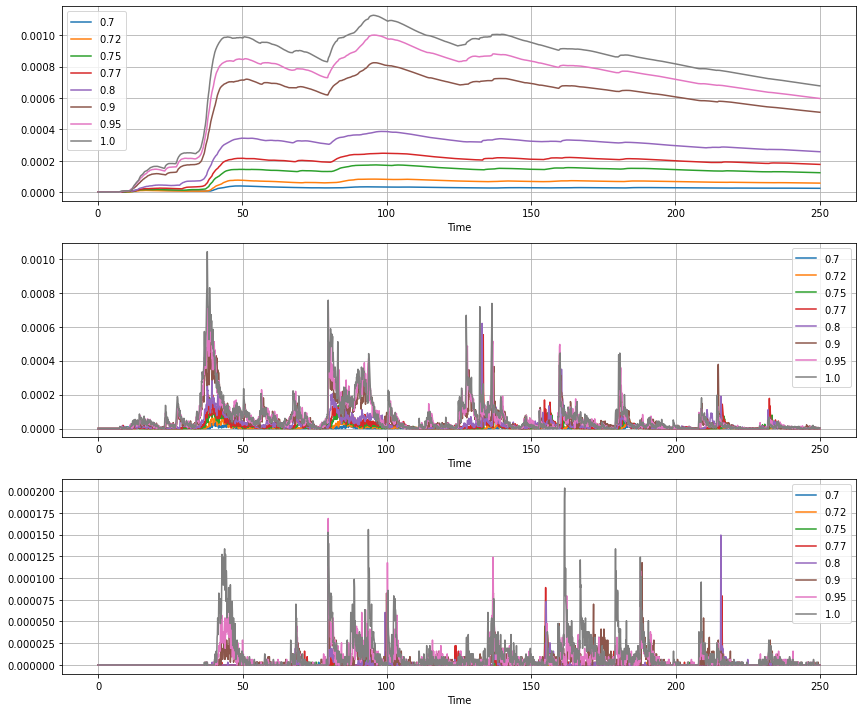

In [8]:
fig,ax = plt.subplots(3,1,figsize=(12,10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)

for alph in alpha_values:
# for alph in [alpha_values[-1]]:
    with h5py.File(prtcl_loadPath(alph) / f"caus-details.hdf5",'r') as f:
        cond = (times<= T)*(times>0)
        ax[0].plot(times[cond],f['Caustics_ratio'][cond]/times[cond],label=f'${alph}$')
        ax[1].plot(f['times'][:],f['new_caus'][:],label=f'${alph}$')
        ax[2].plot(f['times'][:],f['same_caus'][:],label=f'${alph}$')
    
for i in range(3):
    ax[i].set_xlabel('Time')
    ax[i].legend()
    ax[i].grid()
fig.tight_layout()

# fig.savefig(savePlot / 'caustics.png',dpi=300)

In [9]:
times.shape
times[-1]

250.0

In [10]:
labels = ["(a)","(b)","(c)","(d)"]
bgcmap = ListedColormap([(0,0,0,0),(.96, .72, .97,0.6)])
Qbins = np.linspace(-1.0,0.5,1001)
Qvals = 0.5*(Qbins[1:]+Qbins[:-1])

# alpha_values = np.array([0.72,1.0])
alpha_values = np.array([0.70,0.72,0.75,0.77,0.8,0.9,0.95,1.0])
cls = ["#219ebc", "#ffb703","#3a5a40"]
norm = TwoSlopeNorm(vmin=-3, vmax=0.0,vcenter = -1.5)
Zbins  = np.linspace(-25,25,1001)
Zvals = 0.5*(Zbins[1:]+Zbins[:-1])
Z2bins = np.linspace(-625,625,1001)
Z2vals = 0.5*(Z2bins[1:]+Z2bins[:-1])
tbins = np.linspace(times[0],times[-1],50)
tvals = 0.5*(tbins[1:]+tbins[:-1])
Q_caus_shifted_pdf = np.zeros((len(alpha_values),len(times),len(Qvals)))
TrZ_caus_shifted_pdf = np.zeros((len(alpha_values),len(times),len(Zvals)))
TrZ2_caus_shifted_pdf = np.zeros((len(alpha_values),len(times),len(Z2vals)))
t_caus_pdf = np.zeros((len(alpha_values),len(tvals)))
mean1 = np.zeros((len(alpha_values),len(times)))
mean2 = np.zeros((len(alpha_values),len(times)))
# lentcaus = 

In [11]:
print(alpha_values)

[0.7  0.72 0.75 0.77 0.8  0.9  0.95 1.  ]


In [12]:
t1 = tt()
for iiii,alph in enumerate(alpha_values):
    
    print(f"Loading alpha = {alph} at {tt() - t1}",end="\r")
    try: 
        with h5py.File(prtcl_loadPath(alph) / f"caus-details.hdf5",'r') as f:
            try: 
                Q_caus_shifted = f['Q_caus_shifted'][:]
                TrZ_caus_shifted = f['TrZ_shifted'][:]
                TrZ2_caus_shifted = f['TrZ2_shifted'][:]
                t_caus_len = f['t_caus_len'][:]
            except : 
                print(f.keys())
                continue
            dtimes = len(times)-len(Q_caus_shifted)
            print(f"dtimes is {dtimes}",end = "\r")
    except FileNotFoundError: 
        print(f"File not found for alpha = {alph}")
        continue
    
    isnan = 0.
    slc = slice(dtimes,None) if dtimes >= 0 else slice(None,None)
    print(times[slc].shape)
    for i,time in enumerate(times[slc]):  
        offset = 0 if dtimes<0 else dtimes
        isnan = np.isnan(Q_caus_shifted[i]).sum()
        Q_caus_shifted_pdf[iiii,i+offset] = np.histogram(Q_caus_shifted[i],bins = Qbins,density = True)[0]
        TrZ_caus_shifted_pdf[iiii,i+offset] = np.histogram(TrZ_caus_shifted[i],bins = Zbins,density = True)[0]
        TrZ2_caus_shifted_pdf[iiii,i+offset] = np.histogram(TrZ2_caus_shifted[i],bins = Z2bins,density = True)[0]
        t_caus_pdf[iiii] = np.histogram(t_caus_len,bins = 
        tbins,density = True)[0]*(tbins[1]-tbins[0])
    print(f"\nfor alpha = {alph} isnan = {isnan}\n Causcount = {Q_caus_shifted.shape}")    
    
    
    
    # t_caus_pdf[iiii] = t_caus_pdf[iiii]/np.where(np.sum(t_caus_pdf[iiii]) == 0, np.inf, np.sum(t_caus_pdf[iiii]))
    
    mean1[iiii] = np.sum(Qvals[None,:]*Q_caus_shifted_pdf[iiii],axis = 1)*(Qbins[1]-Qbins[0])
    print(dtimes)
    if dtimes >=0:
        mean2[iiii,dtimes:] = np.nanmean(np.where(Q_caus_shifted ==65536, np.nan,Q_caus_shifted),axis = 1)
        # mean2[iiii,dtimes:] = np.nanmean(np.where(TrZ_caus_shifted ==65536, np.nan,TrZ_caus_shifted),axis = 1)
    else: 
        mean2[iiii] = np.nanmean(np.where(Q_caus_shifted ==65536, np.nan,Q_caus_shifted),axis = 1)[:-1]
        # mean2[iiii] = np.nanmean(np.where(TrZ_caus_shifted ==65536, np.nan,TrZ_caus_shifted),axis = 1)[:-1]

    t1 = tt()
    
Q_caus_shifted_pdf[:] = Q_caus_shifted_pdf*(Qbins[1]-Qbins[0])
TrZ_caus_shifted_pdf[:] = TrZ_caus_shifted_pdf*(Zbins[1]-Zbins[0])
TrZ2_caus_shifted_pdf[:] = TrZ2_caus_shifted_pdf*(Z2bins[1]-Z2bins[0])

(2472,)is 29a = 0.7 at 0.0005280971527099609


/home/rajarshi.chattopadhyay/mambaforge/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges



for alpha = 0.7 isnan = 0
 Causcount = (2472, 1929)
29


/tmp/ipykernel_27225/1462692335.py:41: RuntimeWarning: Mean of empty slice
  mean2[iiii,dtimes:] = np.nanmean(np.where(Q_caus_shifted ==65536, np.nan,Q_caus_shifted),axis = 1)


(2448,)is 53

for alpha = 0.72 isnan = 0
 Causcount = (2448, 4582)
53
(2429,)is 72a = 0.75 at 1.3828277587890625e-05

for alpha = 0.75 isnan = 0
 Causcount = (2429, 10007)
72
(2471,)is 30a = 0.77 at 1.3589859008789062e-05

for alpha = 0.77 isnan = 0
 Causcount = (2471, 14568)
30
(2495,)is 6ha = 0.8 at 1.3113021850585938e-05

for alpha = 0.8 isnan = 0
 Causcount = (2495, 21276)
6
(2500,)is 1ha = 0.9 at 1.3113021850585938e-05

for alpha = 0.9 isnan = 0
 Causcount = (2500, 43879)
1
(2498,)is 3ha = 0.95 at 1.621246337890625e-05

for alpha = 0.95 isnan = 0
 Causcount = (2498, 51854)
3
(2501,)is -1a = 1.0 at 1.4066696166992188e-05

for alpha = 1.0 isnan = 0
 Causcount = (2502, 61271)
-1


/tmp/ipykernel_27225/1462692335.py:44: RuntimeWarning: Mean of empty slice
  mean2[iiii] = np.nanmean(np.where(Q_caus_shifted ==65536, np.nan,Q_caus_shifted),axis = 1)[:-1]


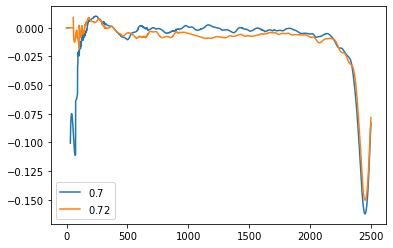

In [20]:
plt.plot(mean2[0],label = f'${alpha_values[0]}$')
plt.plot(mean2[1],label = f'${alpha_values[1]}$')
plt.legend()

[-0.34517012  0.22483997]


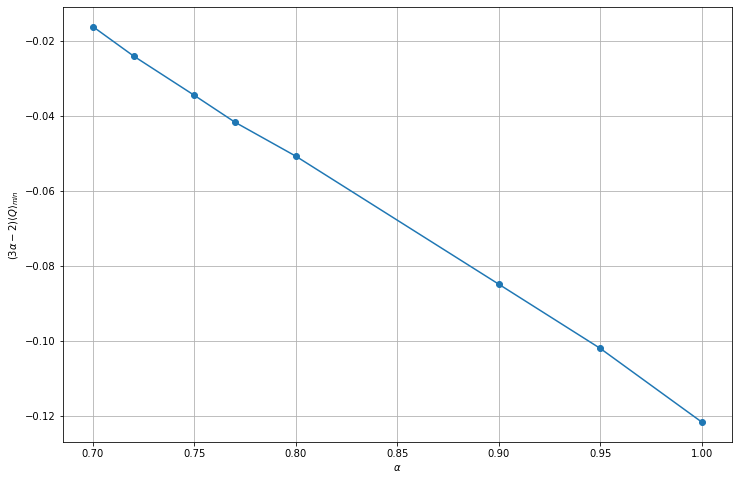

In [13]:
np.sum(t_caus_pdf,axis = 1)
minQ = np.nanmin(mean1,axis = 1)
mpl.rc("text", usetex = False)
fig,ax = plt.subplots(1,1,figsize = (12,8))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
cond = np.ones_like(alpha_values,dtype = bool)
xdat = alpha_values[cond]
ydat = (minQ)[cond]*(3*xdat - 2)# (5/7 -1 + 1-xdat)

# ydat = (minQ)[cond]*(3*xdat - 2)

fit = np.polyfit(xdat,ydat,1)
print(fit)
ax.plot(xdat,ydat,'o-')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$(3\alpha-2)\langle Q\rangle_{min}$')
# plt.plot(xdat,fit_array[0]*xdat+fit_array[1])
ax.grid()

/tmp/ipykernel_16835/1336918092.py:16: RuntimeWarning: divide by zero encountered in log10
  ydat = np.log10(Q_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()][0,cond].T)


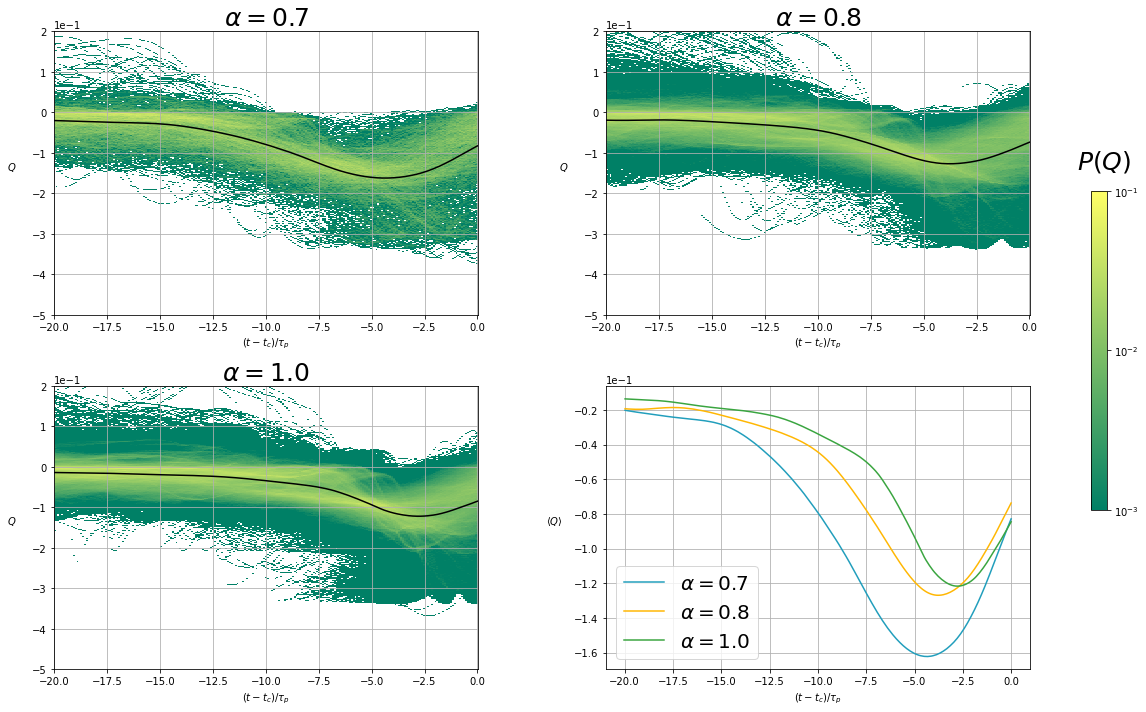

In [22]:
times_rescaled = (times - times[-1])*tp
cond = times_rescaled>-20.0
alphs = [0.7,0.8,1.0] 

mpl.rc("text", usetex = False)
labels = ["(a)","(b)","(c)","(d)"]
cls = ["219ebc","ffb703","3aa540"]
fig,ax = plt.subplots(2,2,figsize=(18,10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
norm = TwoSlopeNorm(vmin=-3, vmax=-1,vcenter=-2)
for i,alph in enumerate(alphs):
    ind1 = i//2
    ind2 = i%2
    xdat = times_rescaled[cond]
    ydat = np.log10(Q_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()][0,cond].T)
    ax[ind1,ind2].pcolormesh(xdat,Qvals,ydat,cmap = "summer",norm = norm)    
    # ax[ind1,ind2].contourf(xdat,Qvals,Qreg,2, cmap = bgcmap)
    ydat = mean1[np.argwhere(alpha_values == alph).ravel()][0,cond]
    ax[ind1,ind2].plot(xdat,ydat, 'black')
    ax[ind1,ind2].set_title(fr"$\alpha = {alph}$",fontsize = 25)
    ax[ind1,ind2].set_ylabel(r'$Q$',rotation = 0,labelpad =20)

    ax[1,1].plot(xdat,ydat,color ="#" + cls[i],label = fr"$ \alpha = {alph}$")
    ax[ind1,ind2].set_ylim(-0.5,0.2)
    ax[ind1,ind2].ticklabel_format(style='sci', axis='y', scilimits=(0, -1))
    
for axs in ax.ravel():
    axs.set_xlabel(r'$(t-t_c)/\tau_p$')
    
    axs.grid()
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[1,1].legend(fontsize = 20)    
ax[1,1].set_ylabel(r"$\langle Q \rangle$",rotation = 0,labelpad =20)    
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
cbar = fig.colorbar(ax[0,0].collections[0], ax=ax, location='right', shrink=0.5)
cbar.set_ticks([-1, -2, -3])
fig.text(0.855, 0.76, r"$P(Q)$", ha='center',fontsize = 25)
cbar.set_ticklabels([r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$'])

In [15]:
minQ = np.nanmin(mean1,axis = 1)
argminQ = np.argwhere(mean1 <= minQ[:,None])[:,1]


In [24]:
plt.rcParams.update({'axes.labelsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20})

array([-0.70851265,  0.78372501, -0.03743628])

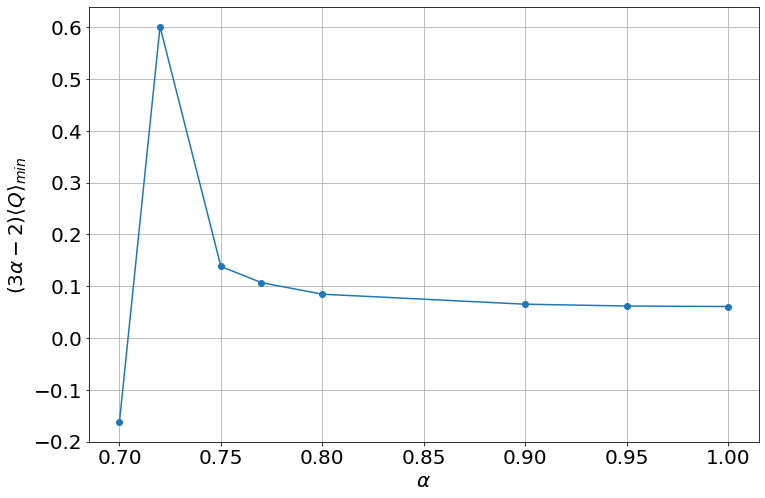

In [30]:
mpl.rc("text", usetex = False)
fig,ax = plt.subplots(1,1,figsize = (12,8))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
cond = np.ones_like(alpha_values,dtype = bool)
xdat = alpha_values
ydat = (minQ)*(3*xdat - 2) /(5-7*xdat)
# ydat = (minQ)[cond]*(3*xdat - 2)

fit = np.polyfit(xdat,ydat,2)
ax.plot(xdat,ydat,'o-')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$(3\alpha-2)\langle Q\rangle_{min}$')
# plt.plot(xdat,fit_array[0]*xdat+fit_array[1])
ax.grid()
fit

In [27]:
lastQ = mean1[:,-1]

array([-0.2447352 ,  0.1705725 , -0.00894198])

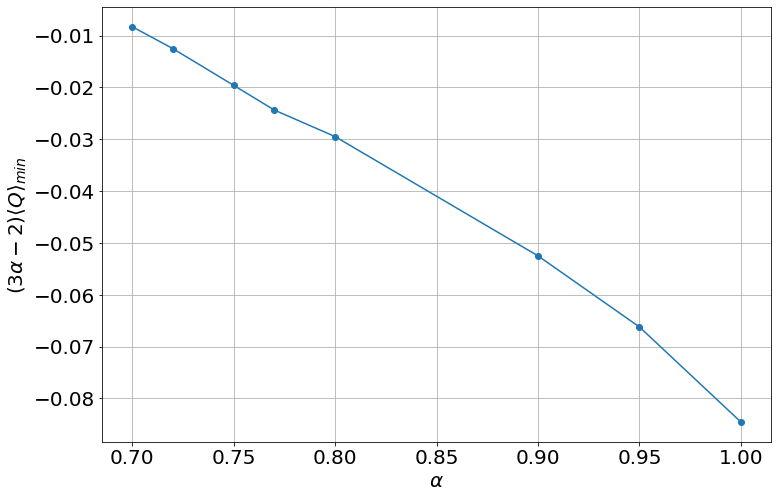

In [28]:
mpl.rc("text", usetex = False)
fig,ax = plt.subplots(1,1,figsize = (12,8))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
cond = np.ones_like(alpha_values,dtype = bool)
xdat = alpha_values[cond]
ydat = (lastQ)[cond]*(3*xdat - 2)
# ydat = (minQ)[cond]*(3*xdat - 2)

fit = np.polyfit(xdat,ydat,2)
ax.plot(xdat,ydat,'o-')
ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$(3\alpha-2)\langle Q\rangle_{min}$')
# plt.plot(xdat,fit_array[0]*xdat+fit_array[1])
ax.grid()
fit

In [30]:
fit_array = (np.array([-0.24155134,  0.16208212]) + np.array([-0.24155134,  0.16208212]))/2.0

# <center> $t_c$ pdf

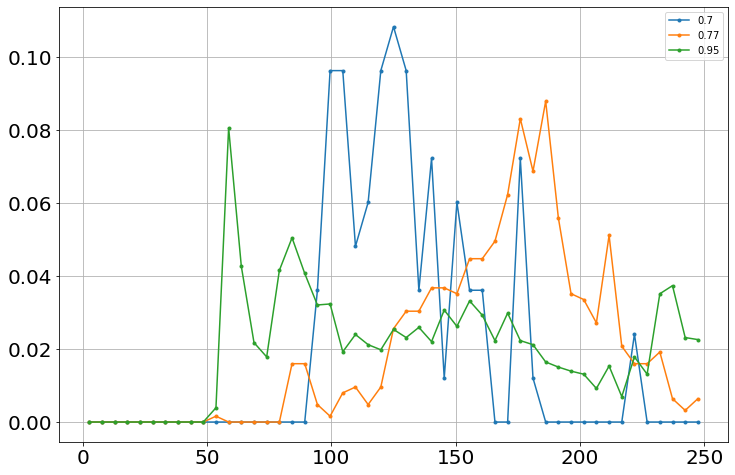

In [31]:
mpl.rc("text", usetex = False)
fig,ax = plt.subplots(1,1,figsize = (12,8))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
for i,alph in enumerate(alpha_values):
    if i%3==0: ax.plot(tvals,t_caus_pdf[i],'.-',label = f"{alph}")
    
ax.legend()
ax.grid()

In [32]:
Q_field_pdf = []
Q_particle_pdf = []
Q_caus_pdf = []
Qbins_old = np.linspace(-0.5,0.5, 6001)
Qvals_old = 0.5*(Qbins_old[1:]+Qbins_old[:-1])

# <center> Final Q pdfs

In [33]:
for i, alph in enumerate(alpha_values):
    with h5py.File(prtcl_loadPath(alph) / f"caus-details.hdf5",'r') as f:
        Q_field_pdf.append(f['Q_field_pdf'][:]/(Qbins[1]-Qbins[0]))
        Q_particle_pdf.append(f['Q_particle_pdf'][:]/(Qbins[1]-Qbins[0]))
        Q_caus_pdf.append(f['Q_caus_pdf'][:]/(Qbins[1]-Qbins[0]))

Q_field_pdf = np.array(Q_field_pdf)
Q_particle_pdf = np.array(Q_particle_pdf)
Q_caus_pdf = np.array(Q_caus_pdf)

In [46]:
# Q_field_pdf = Q_field_pdf/(tp)**2   #! To delete after running the code again. 

In [47]:
Q_field_pdf.sum(), 8*2500*(Qbins[1]-Qbins[0])

(16467489.711935544, 29.999999999998916)

In [48]:
Q_field_time_averaged_pdf = np.sum(Q_field_pdf,axis = 1)/len(times)
Q_particle_time_averaged_pdf = np.sum(Q_particle_pdf,axis = 1)/len(times)
Q_caus_time_averaged_pdf = np.sum(Q_caus_pdf,axis = 1)/len(times)

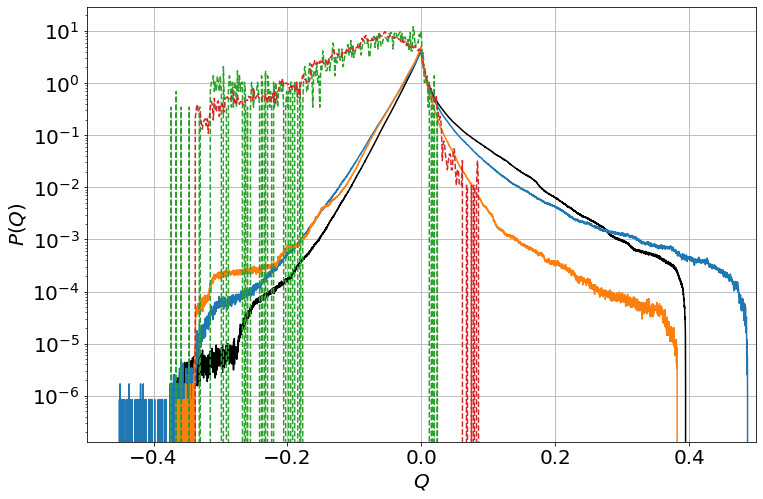

In [49]:
mpl.rc("text", usetex = False)
fig,ax = plt.subplots(1,1,figsize = (12,8))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
xdat = Qvals_old
ydat = Q_field_time_averaged_pdf[0]
# ax.plot(xdat,ydat,color ='black')
ax.plot(xdat*tp**2,ydat,color ='black')
ydat = Q_particle_time_averaged_pdf[0]
ax.plot(xdat,ydat,label = r"$\alpha = 0.7$")
ydat = Q_particle_time_averaged_pdf[-1]
ax.plot(xdat,ydat,label = r"$\alpha = 1.0$")
ydat = Q_caus_shifted_pdf[0,-1]/(Qbins[1]- Qbins[0])
ax.plot(Qvals,ydat,label = r"$\alpha = 0.7$",linestyle = "--")
ydat = Q_caus_shifted_pdf[-1,-1]/(Qbins[1]- Qbins[0])
ax.plot(Qvals,ydat,label = r"$\alpha = 1.0$",linestyle = "--")
# ydat = Q_caus_shifted_pdf[0,argminQ[0]]/(Qbins[1]- Qbins[0])
# ax.plot(Qvals,ydat,label = r"$\alpha = 0.7$",linestyle = "--")
# ydat = Q_caus_shifted_pdf[-1,argminQ[-1]]/(Qbins[1]- Qbins[0])
# ax.plot(Qvals,ydat,label = r"$\alpha = 1.0$",linestyle = "--")

# ydat = (minQ)[cond]*(3*xdat - 2)
ax.set_yscale('log')
ax.set_xlim(-0.5,0.5)
ax.set_xlabel(r'$Q$')
ax.set_ylabel(r'$P(Q)$')
# plt.plot(xdat,fit_array[0]*xdat+fit_array[1])
ax.grid()

# <center> Tr(Z) pdf

/tmp/ipykernel_16835/643578117.py:16: RuntimeWarning: divide by zero encountered in log10
  ydat = np.log10(TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()][0,cond].T)


(223,)
(223,)
(223,)


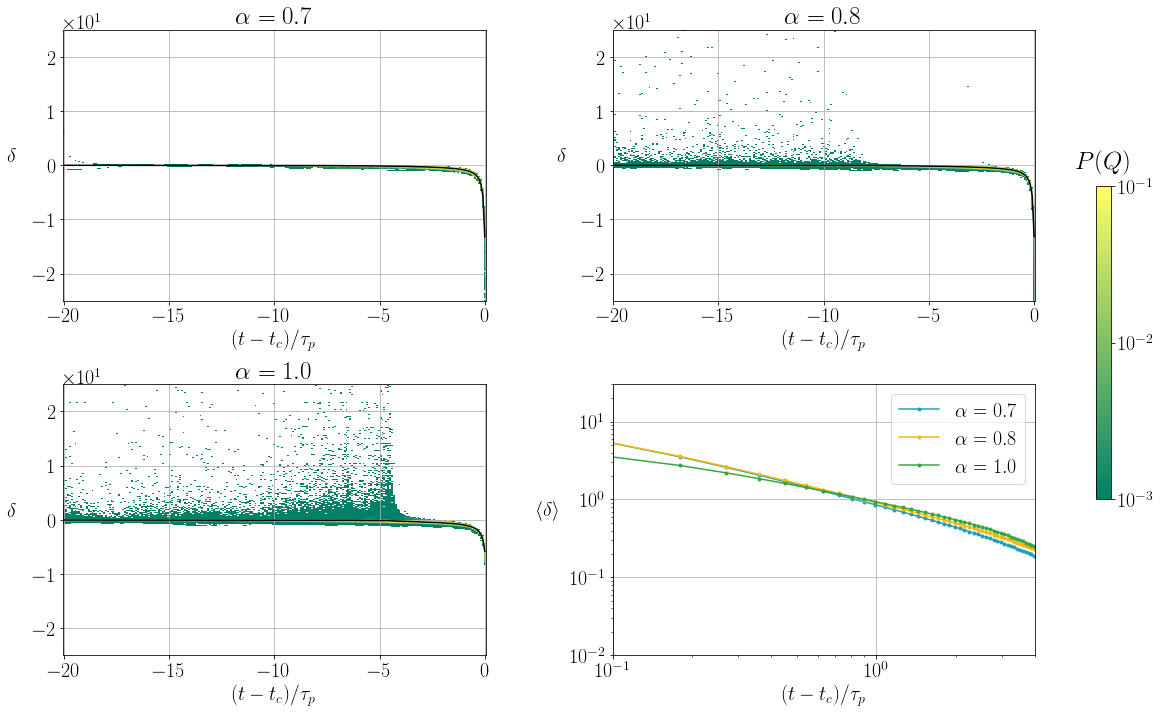

In [50]:
times_rescaled = (times - times[-1])*tp
cond = times_rescaled>-20.0
alphs = [0.7,0.8,1.0] 

mpl.rc("text", usetex = True)
labels = ["(a)","(b)","(c)","(d)"]
cls = ["219ebc","ffb703","3aa540"]
fig,ax = plt.subplots(2,2,figsize=(18,10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
norm = TwoSlopeNorm(vmin=-3, vmax=-1,vcenter=-2)
for i,alph in enumerate(alphs):
    ind1 = i//2
    ind2 = i%2
    xdat = times_rescaled[cond]
    ydat = np.log10(TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()][0,cond].T)
    ax[ind1,ind2].pcolormesh(xdat,Zvals,ydat,cmap = "summer",norm = norm)    
    # ax[ind1,ind2].contourf(xdat,Qvals,Qreg,2, cmap = bgcmap)
    ydat = np.sum(Zvals[None,None,:]*TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()],axis =2)[0,cond]
    print(ydat.shape)
    ax[ind1,ind2].plot(xdat,ydat, 'black')
    ax[ind1,ind2].set_title(fr"$\alpha = {alph}$",fontsize = 25)
    ax[ind1,ind2].set_ylabel(r'$\delta$',rotation = 0,labelpad =20)

    ax[1,1].plot(-xdat[:-1],-ydat[:-1],'.-',color ="#" + cls[i],label = fr"$ \alpha = {alph}$")
    # ax[ind1,ind2].set_ylim(-0.5,0.2)
    ax[ind1,ind2].ticklabel_format(style='sci', axis='y', scilimits=(0, -1))
    
for axs in ax.ravel():
    axs.set_xlabel(r'$(t-t_c)/\tau_p$')
    
    axs.grid()
ax[1,1].ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax[1,1].legend(fontsize = 20)    
ax[1,1].set_ylabel(r"$\langle \delta \rangle$",rotation = 0,labelpad =20)    
ax[1,1].set_yscale('log')
ax[1,1].set_xscale('log')
ax[1,1].set_ylim(1e-2,30)
ax[1,1].set_xlim(0.1,4)
fig.tight_layout()
fig.subplots_adjust(wspace=0.3)
cbar = fig.colorbar(ax[0,0].collections[0], ax=ax, location='right', shrink=0.5)
cbar.set_ticks([-1, -2, -3])
fig.text(0.855, 0.76, r"$P(Q)$", ha='center',fontsize = 25)
cbar.set_ticklabels([r'$10^{-1}$', r'$10^{-2}$', r'$10^{-3}$'])

In [ ]:

len(cls),len(alpha_values)

(3, 8)

[-0.84299666 -0.18165   ]
[-0.832616   -0.16536068]
[-0.82332706 -0.14718582]
[-0.819458   -0.13769779]
[-0.80252455 -0.10539427]
[-0.77682512 -0.05006944]
[-0.76560787 -0.02735962]
[-0.64071063 -0.09197904]


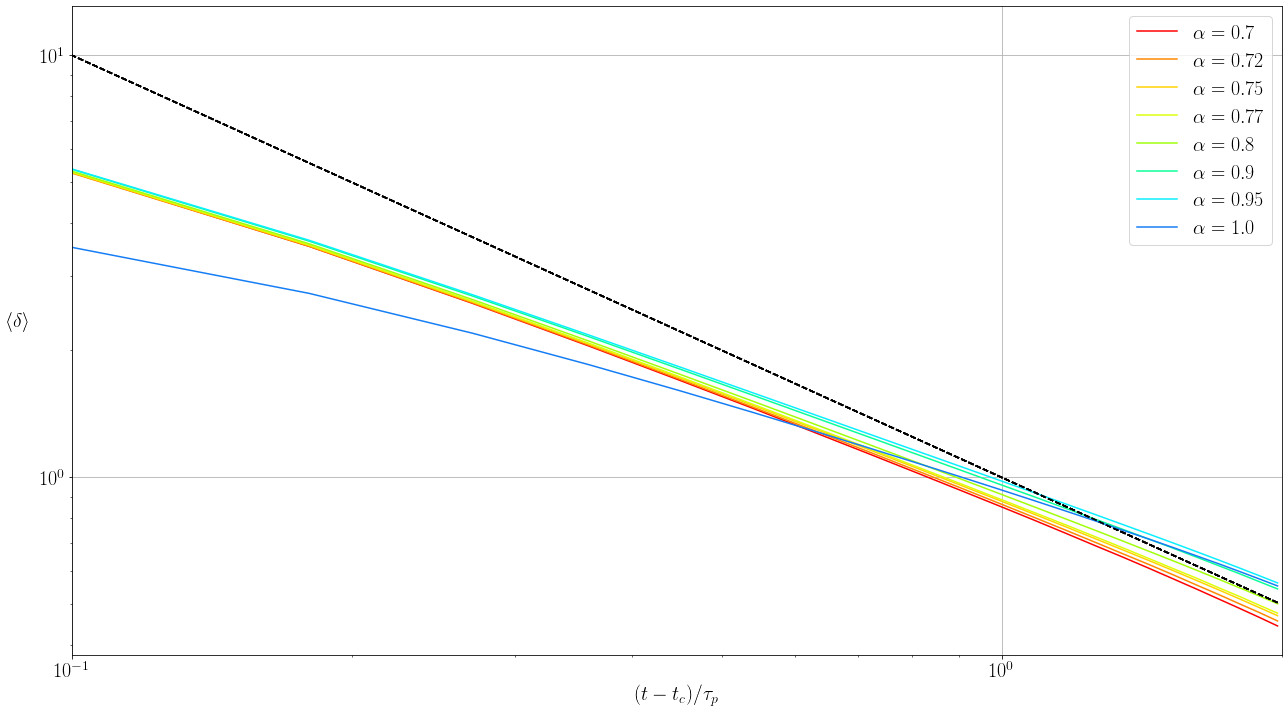

In [ ]:
times_rescaled = (times - times[-1])*tp
cond = (times_rescaled>-2.0)
alphs = [0.7,0.8,1.0] 

mpl.rc("text", usetex = True)
labels = ["(a)","(b)","(c)","(d)"]
cls = ["ff0000","ff8700","ffd300","deff0a","a1ff0a","0aff99","0aefff","147df5","580aff","be0aff"]
fig,ax = plt.subplots(1,1,figsize=(18,10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
norm = TwoSlopeNorm(vmin=-3, vmax=-1,vcenter=-2)
for i,alph in enumerate(alpha_values):
    xdat = times_rescaled[cond]
    
    ydat = np.sum(Zvals[None,None,:]*TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()],axis =2)[0,cond]
    # ydat = mean2[np.argwhere(alpha_values == alph).ravel()][0,cond]
    ax.plot(-xdat[:-1],-ydat[:-1],color = "#" + cls[i],label = fr"$ \alpha = {alph}$")
    fit = np.polyfit(np.log(-xdat[:-1]),np.log(-ydat[:-1]),1)
    print(fit)
    ydat = 1*(-xdat[:-1])**(-1.0)
    ax.plot(-xdat[:-1],ydat, '--',color= 'black')
    # ax[ind1,ind2].set_ylim(-0.5,0.2)
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -1))  
ax.set_xlabel(r'$(t-t_c)/\tau_p$')  
ax.grid()
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.legend(fontsize = 20)    
ax.set_ylabel(r"$\langle \delta \rangle$",rotation = 0,labelpad =20)    
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(1e-2,30)
ax.set_xlim(0.1,2)
fig.tight_layout()

In [63]:
Z_crit = np.sum(Zvals[None,None,:]*TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()],axis =2)[0][argminQ[-1]]
Z_crit

-0.3991247898679679

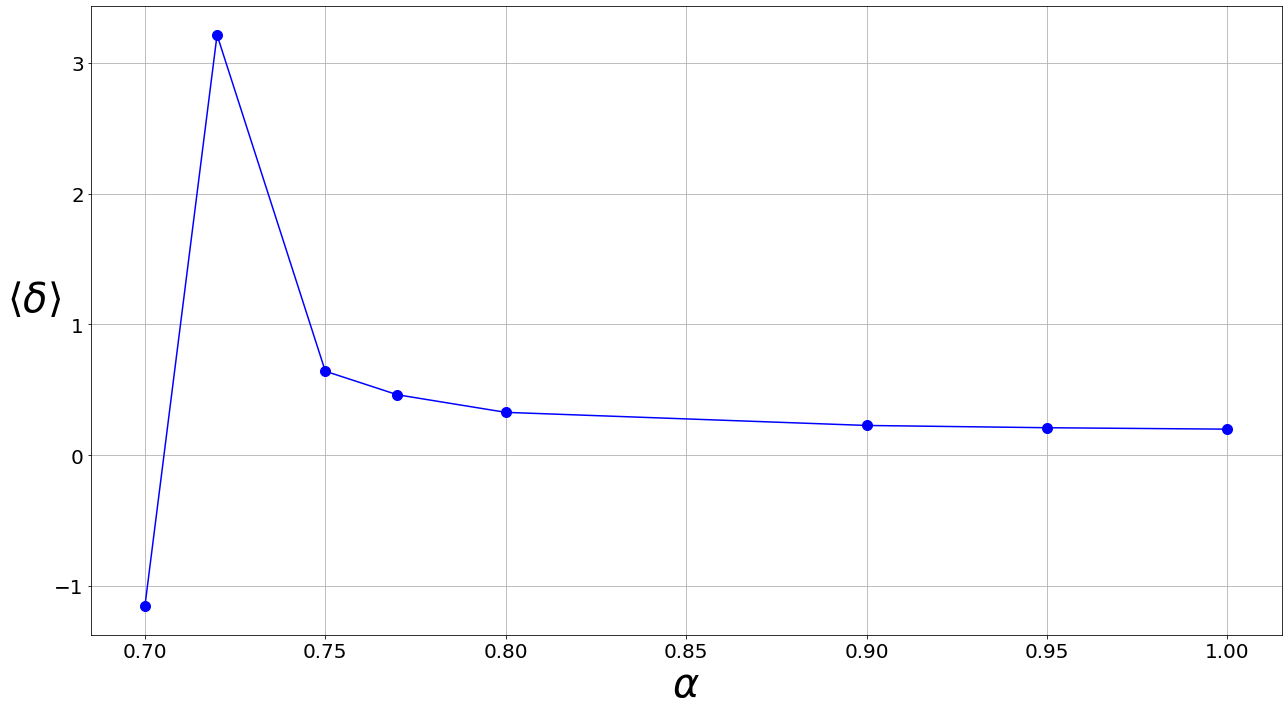

In [34]:
times_rescaled = (times - times[-1])*tp
cond = (times_rescaled>-2.0)
alphs = [0.7,0.8,1.0] 

mpl.rc("text", usetex = False)
labels = ["(a)","(b)","(c)","(d)"]
cls = ["ff0000","ff8700","ffd300","deff0a","a1ff0a","0aff99","0aefff","147df5","580aff","be0aff"]
fig,ax = plt.subplots(1,1,figsize=(18,10))
fig.patch.set_facecolor('white')
fig.patch.set_alpha(1.0)
norm = TwoSlopeNorm(vmin=-3, vmax=-1,vcenter=-2)
Z_crit = np.zeros_like(alpha_values)
for i,alph in enumerate(alpha_values):
    
    Z_crit[i] = np.sum(Zvals[None,None,:]*TrZ_caus_shifted_pdf[np.argwhere(alpha_values == alph).ravel()],axis =2)[0,argminQ[i]]
    
# xdat = np.log(minQ*(3*alpha_values - 2)/(5-7*alpha_values))
xdat = alpha_values
# ydat = (Z_crit*xdat)/(minQ*(3*xdat - 2))
ydat = Z_crit*xdat/(5-7*xdat)
ax.plot(xdat, ydat,'o-',color = 'b',markersize = 10)
# ax.ticklabel_format(style='sci', axis='y', scilimits=(0, -1))  
ax.set_xlabel(r'$\alpha$',fontsize = 40)  
ax.grid()
# ax.legend(fontsize = 20)    
ax.set_ylabel(r"$\langle \delta \rangle$",rotation = 0,labelpad =20,fontsize = 40)    
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_ylim(1e-2,30)
fig.tight_layout()

In [38]:
data = [alpha_values,Z_crit,minQ,Z_crit/minQ]
data = np.array(data).T
data.shape

(8, 4)

In [39]:
np.savetxt(loadPath/'data.txt',data,header = "alpha Z_crit minQ")

In [40]:
print(loadPath)

data_spline/Re_100000.0,dt_0.01,N_1024
